In [1]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from math import *

In [33]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    gradmag = np.uint8( 255 * gradmag / np.max(gradmag))

    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def red_thres(img, thresh_min = 25, thresh_max = 255):
    red = img[:,:,2]
    red_binary = np.zeros_like(red)
    red_binary[(red >= thresh_min) & (red <= thresh_max)]  = 1
    return red_binary

def threshold_for_s_channel(img, thresh=(25, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary

def threshold_for_l_channel(img, thresh=(25, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    l_channel = (255/np.max(l_channel)) * l_channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return l_binary

#good for yellow lines
def lab_bthresh(img, thresh=(200,255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    return binary_output

def combine_thresholds(img,s_thresh = (200, 255), l_thresh = (200, 255), 
                       sx_thresh = (0, 255), lab_tresh_vals = (190,255), mask_half = True):
    l_binary = threshold_for_l_channel(img,thresh = l_thresh)
    s_binary = threshold_for_s_channel(img,thresh = s_thresh)

    sxbinary = abs_sobel_thresh(img, thresh = sx_thresh)
    gray = (0.5*img[:,:,0] + 0.4*img[:,:,1] + 0.1*img[:,:,2]).astype(np.uint8)   
    _, gray_binary = cv2.threshold(gray.astype('uint8'), 70, 255, cv2.THRESH_BINARY)
        
    lab_tresh = lab_bthresh(img, thresh=lab_tresh_vals)
    
    combined_binary = np.zeros_like(lab_tresh)
    combined_binary[(gray_binary == 1) & ((s_binary == 1)) | ((l_binary == 1)) | ((lab_tresh == 1))] = 1

    return combined_binary

def calibrate_and_undistort(img, objpoints, imgpoints, nx, ny):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    return cv2.undistort(img, mtx, dist, None, mtx)

def build_transformation_matricies(img):
    img_size = img.shape    
    src = np.array([[585. /1280.*img_size[1], 455./720.*img_size[0]],
                        [705. /1280.*img_size[1], 455./720.*img_size[0]],
                        [1130./1280.*img_size[1], 720./720.*img_size[0]],
                        [190. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)

        
    dst = np.array([[300. /1280.*img_size[1], 100./720.*img_size[0]],
                        [1000./1280.*img_size[1], 100./720.*img_size[0]],
                        [1000./1280.*img_size[1], 720./720.*img_size[0]],
                        [300. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv



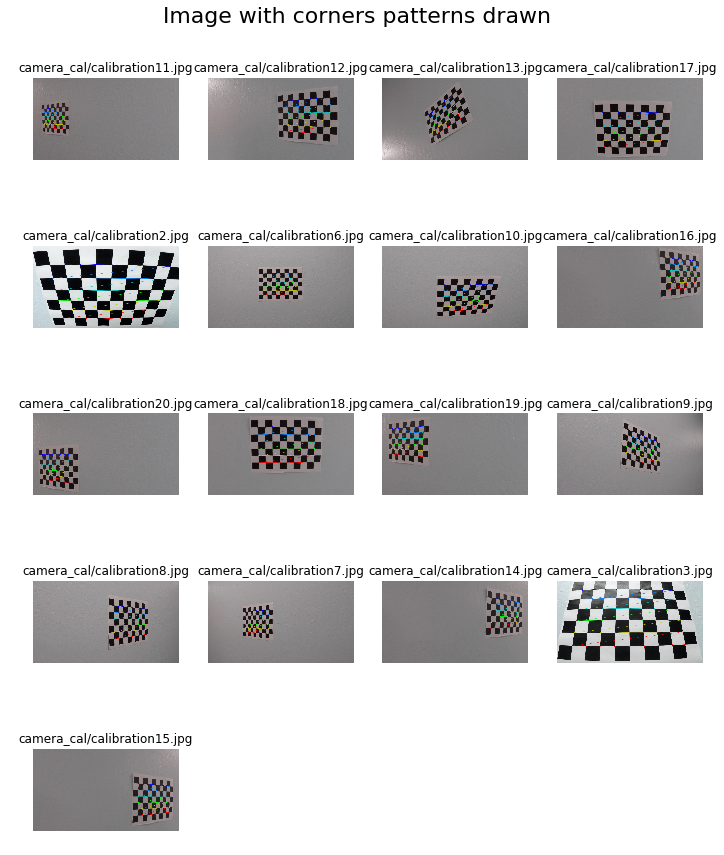

In [3]:
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

nx = 9
ny = 6

images = glob.glob('camera_cal/calibration*.jpg')

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

plt.figure(figsize=(12, 18)) #Figure for calibration images
plt.figtext(0.5,0.9,'Image with corners patterns drawn', fontsize=22, ha='center')
counter = 0
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Conver to grayscale
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        counter += 1
        
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.subplot(6, 4, counter)        
        plt.imshow(img) #draw the first image of each class
        plt.title(fname)
        plt.axis('off')

plt.show()        



In [4]:
#get global camera calibration params
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

def undistort_image(img):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    return cv2.undistort(img, mtx, dist, None, mtx)

Before undistortion and calibration:


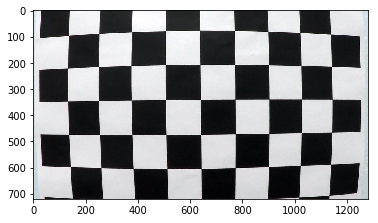

After undistortion and calibration:


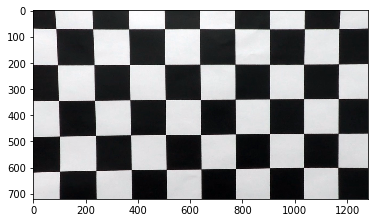

Test image before undistortion and calibration:


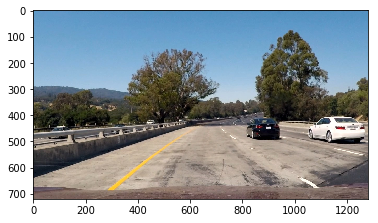

Test image after undistortion and calibration:


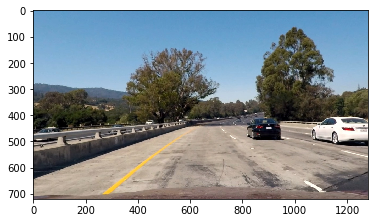

In [5]:
test_image = cv2.imread('./camera_cal/calibration1.jpg')
print("Before undistortion and calibration:")
plt.imshow(test_image.squeeze(), cmap="gray")
plt.show()

undistorted = undistort_image(test_image)
print("After undistortion and calibration:")
plt.imshow(undistorted.squeeze(), cmap="gray")
plt.show()
gray
real_image = cv2.imread('test_images/test1.jpg')
print("Test image before undistortion and calibration:")
real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)
plt.imshow(real_image.squeeze(), cmap="gray")
plt.show()

real_image = undistort_image(real_image)
print("Test image after undistortion and calibration:")
plt.imshow(real_image.squeeze(), cmap="gray")

plt.show()

In [6]:
def blur_image(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)

def image_transformation_pipeline(img, M):
    undist = undistort_image(img)
    warped = cv2.warpPerspective(undist, M, (img.shape[1], img.shape[0]))
    #warped = blur_image(warped)
    return warped

def image_preprocessing_pipeline(img, M, warping_first = False):
    img = undistort_image(img)
    #img = blur_image(img)
    if warping_first == True:
        img = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))        
    img = combine_thresholds(img, s_thresh = (255, 255), l_thresh = (210, 255), 
                             sx_thresh = (60, 100), lab_tresh_vals = (190, 255))
    if warping_first == False:
        img = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))    
    return img

Test image before processing:


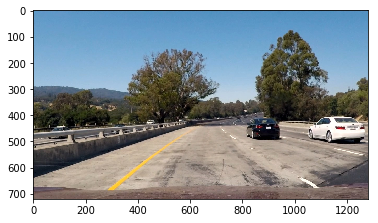

Test image after bird eye warping:


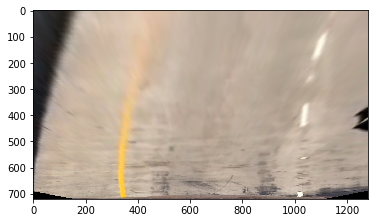

Test image after bird eye warping and color thresholding:


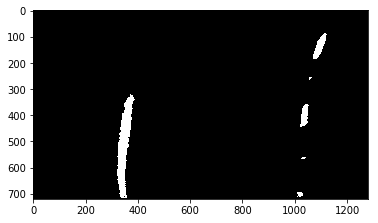

Test image after color thresholding and bird eye warping:


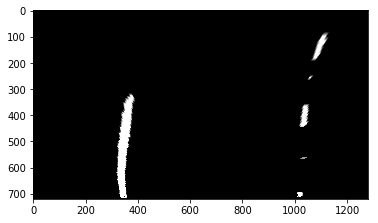

In [34]:
real_image = cv2.imread('test_images/test1.jpg')
print("Test image before processing:")
real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)
plt.imshow(real_image.squeeze(), cmap="gray")
plt.show()

M, Minv = build_transformation_matricies(real_image)
bird_eyed = image_transformation_pipeline(real_image, M)
print("Test image after bird eye warping:")
plt.imshow(bird_eyed.squeeze(), cmap="gray")
plt.show()

color_thresholded = image_preprocessing_pipeline(real_image, M, warping_first = True)
#color_thresholded = combine_thresholds(real_image, s_thresh = (150, 255), sx_thresh = (40, 150))
print("Test image after bird eye warping and color thresholding:")
plt.imshow(color_thresholded.squeeze(), cmap="gray")
plt.show()

binary_warped = image_preprocessing_pipeline(real_image, M, warping_first = False)
#color_thresholded = combine_thresholds(real_image, s_thresh = (150, 255), sx_thresh = (40, 150))
print("Test image after color thresholding and bird eye warping:")
plt.imshow(binary_warped.squeeze(), cmap="gray")
plt.show()


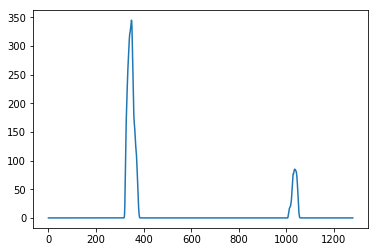

In [8]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

...


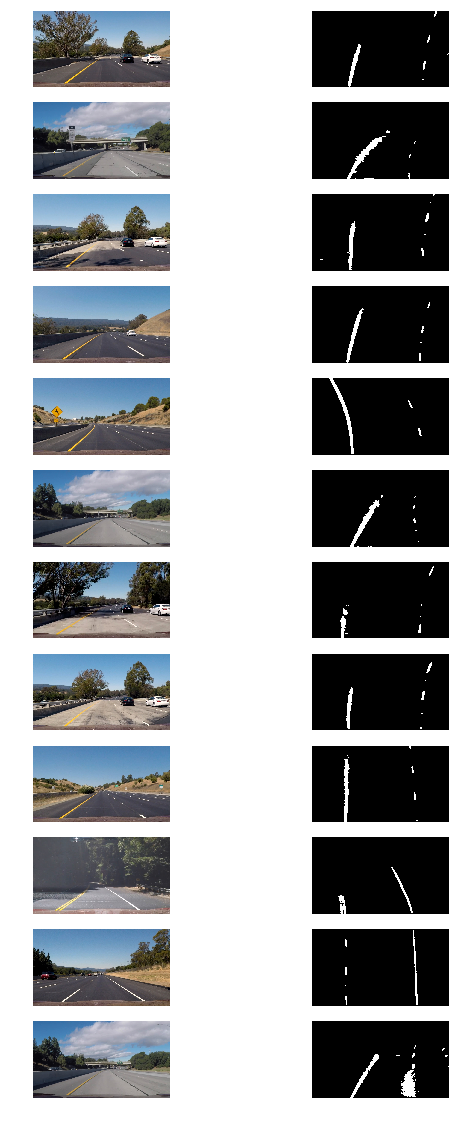

In [10]:
import imageio
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin = image_preprocessing_pipeline(img, M, warping_first = True)       
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1
    
print('...')
plt.show()


In [20]:
def build_lines_from_scratch(binary_warped, display = False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices    
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    #leftx, lefty = reject_outliers(leftx, lefty)
    #rightx, righty = reject_outliers(rightx, righty)

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if display == True:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()    
    return left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds


def build_lines_from_prev_points(binary_warped, left_fit, right_fit, display = False):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #leftx, lefty = reject_outliers(leftx, lefty)
    #rightx, righty = reject_outliers(rightx, righty)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if display == True:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    return left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds    

def calculate_distance_from_center(img, left_fit, right_fit, xm_per_pix):
    image_center = img.shape[1]/2
    image_height = img.shape[0]
    center_dist = 0
    if left_fit is not None and right_fit is not None:
        car_position = image_center
        left_fit_x_intercept = left_fit[0]*image_height**2 + left_fit[1]*image_height + left_fit[2]
        right_fit_x_intercept = right_fit[0]*image_height**2 + right_fit[1]*image_height + right_fit[2]
        center_dist = xm_per_pix * (car_position - (left_fit_x_intercept + right_fit_x_intercept) / 2)
    return center_dist   

def calculate_radius_and_distance_from_center(img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    image_center = img.shape[1]/2
    image_height = img.shape[0]
    
    ploty = np.linspace(0, image_height - 1, image_height)
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]    
    
    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
 
    # Calculate distance from center
    distance_from_center = calculate_distance_from_center(img, left_fit, right_fit, xm_per_pix)
        
    return left_curverad, right_curverad, distance_from_center    


def draw_lines(image, warped, left_fit, right_fit, left_curverad, right_curverad, center_dist):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    image_height = img.shape[0]
    ploty = np.linspace(0, image_height - 1, image_height) # to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    new_img = np.copy(result)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text_left= 'Left line radius: ' + '{:04.2f}'.format(left_curverad) + 'm'
    text_right = 'Right line radius: ' + '{:04.2f}'.format(right_curverad) + 'm'

    cv2.putText(new_img, text_left, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    cv2.putText(new_img, text_right, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,170), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    
    return new_img


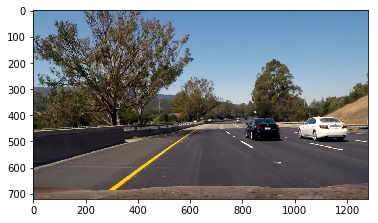

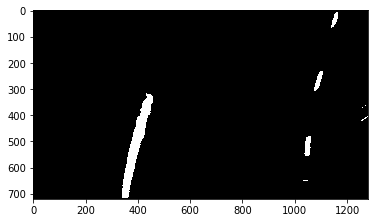

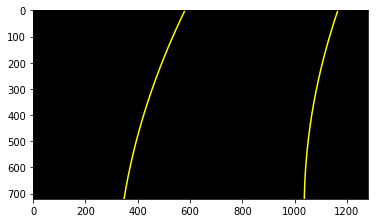

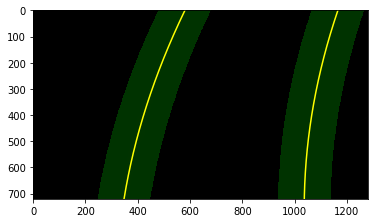

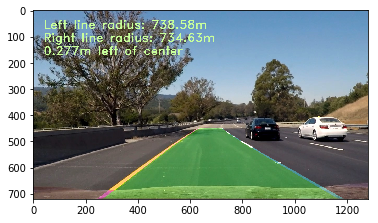

In [21]:

test_img = cv2.imread('test_images/test6.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)

plt.imshow(test_img, cmap='gray')
plt.show()

processed_image = image_preprocessing_pipeline(test_img, M, warping_first = True)

plt.imshow(processed_image, cmap='gray')
plt.show()

left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds = build_lines_from_scratch(processed_image, display = True)

left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds = build_lines_from_prev_points(processed_image, left_fit, right_fit, display = True)

left_curverad, right_curverad, center_dist = calculate_radius_and_distance_from_center(processed_image, left_fit, right_fit, left_lane_inds, right_lane_inds)    

result = draw_lines(test_img, processed_image, left_fit, right_fit, left_curverad, right_curverad, center_dist)
plt.imshow(result)
plt.show()

In [22]:
class Line():        
    def sanity_check_lane(self):       
        return len(self.current_fit) > 0 and (self.diffs[0] > 0.001 or self.diffs[1] > 1 or self.diffs[2] > 100)    
        
    def trackLine(self, fit, inds):        
        if fit is not None:
            if self.best_fit is not None:
                self.diffs = abs(fit-self.best_fit)
            if self.sanity_check_lane():
                self.detected = False
            else:
                self.current_fit.append(fit)
                if len(self.current_fit) > 8:
                    self.current_fit = self.current_fit[len(self.current_fit)-8:]
                self.best_fit = np.average(self.current_fit, axis=0)
                self.px_count = np.count_nonzero(inds)
                self.detected = True
        else:
            if len(self.current_fit) > 0:
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                self.best_fit = np.average(self.current_fit, axis=0)
            self.detected = False
            
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None            
        

In [23]:
def processSingleImage(img):
    copied_img = np.copy(img)
    processed_image = image_preprocessing_pipeline(copied_img, M, warping_first = False)
    
    if not l_line.detected or not r_line.detected:
        left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds = build_lines_from_scratch(processed_image)    
    else:
        left_fit, right_fit, left_fitx, right_fitx, left_lane_inds, right_lane_inds = build_lines_from_prev_points(processed_image, l_line.best_fit, r_line.best_fit)
      
    left_line.trackLine(left_fit, left_lane_inds)
    right_line.trackLine(right_fit, right_lane_inds)
    
    result = copied_img
    if left_line.best_fit is not None and right_line.best_fit is not None:
        left_curverad, right_curverad, center_dist = calculate_radius_and_distance_from_center(processed_image, 
                                                                                               left_fit, right_fit, 
                                                                                               left_lane_inds, 
                                                                                               right_lane_inds)
                                                               
        result = draw_lines(copied_img, processed_image, left_fit, right_fit, left_curverad, right_curverad, center_dist)                                                       
       
    
    return result

In [ ]:
from moviepy.editor import VideoFileClip

left_line = Line()
right_line = Line()
out = 'project_video_output_final.mp4'
inp = VideoFileClip('project_video.mp4')
processed_video = inp.fl_image(processSingleImage)
%time processed_video.write_videofile(out, audio=False)